1. National line plot
2. Fixed regression? R2? across all years
3. Scatterplot
4. Predict next year's GDP using NTL

Sub-national
1. NUTS3 national plot
2. NUTS3 fixed regression, R2 (all regions all years)
3. Scatter all regions byyear/distribution of all regions by  year
4. Predict next years's GDP using NTL

# Analysis of Germany GDP versus harmonized nighttime lights

In [1]:
from analysis.eu_gdp_vs_ntl import *
from harmonizer.main import crop_batch
from harmonizer.plots import plot_timeseries
from harmonizer.diagnostics import get_series
from harmonizer.config import OUTPUT, DMSP_CLIP, VIIRS_CLIP, DATA, VIIRS_IN, DMSP_IN, ROOT

GDPFPATH= Path(ROOT,"files","nama_10r_3gdp.csv")
GEOMPATH = Path(ROOT,"data","geo","ref-nuts-2016-01m.geojson","NUTS_RG_01M_2016_4326.geojson")

## Get unprocessed VIIRS-DNB

1. This notebooks assumes the harmonizer has already been run on Germany and the harmonized time series is located in the `output/` folder.

2. We'll clip the raw input VNL files for comparison:

In [2]:
def crop_raw(din, vin, dout, vout, roipath):
    vout.mkdir(exist_ok=True)
    dout.mkdir(exist_ok=True)
    crop_batch(din, dout, roipath, 1)
    crop_batch(vin, vout, roipath, 1)
    
def normseries(series):
    series = np.asarray(series)
    return (series - np.mean(series)) / np.std(series)
    
DMSP_RAWDE = Path(DATA, "germany_rawDMSP")
VIIRS_RAWDE = Path(DATA, "germany_rawVIIRS")
OUTPUTDE = Path(OUTPUT, "gadm36_DEU_0__XGB")
roipathde = Path(ROOT, "roifiles/gadm36_DEU_shp/gadm36_DEU_0.shp")


DMSP_RAWIT = Path(DATA, "italy_rawDMSP")
VIIRS_RAWIT = Path(DATA, "italy_rawVIIRS")
OUTPUTIT = Path(OUTPUT, "gadm36_ITA_0__XGB")
roipathit = Path(ROOT, "roifiles/gadm36_ITA_shp/gadm36_ITA_0.shp")

DMSP_RAWFR = Path(DATA, "france_rawDMSP")
VIIRS_RAWFR = Path(DATA, "france_rawVIIRS")
OUTPUTFR = Path(OUTPUT, "gadm36_FRA_0__XGB")
roipathfr = Path(ROOT, "roifiles/gadm36_FRA_shp/gadm36_FRA_0.shp")

DMSP_RAWES = Path(DATA, "spain_rawDMSP")
VIIRS_RAWES = Path(DATA, "spain_rawVIIRS")
OUTPUTES = Path(OUTPUT, "gadm36_ESP_0__XGB")
roipathes = Path(ROOT, "roifiles/gadm36_ESP_shp/gadm36_ESP_0.shp")

# to create the clipped "raw" files (only needs to be done once)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWDE, VIIRS_RAWDE, roipathde)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWIT, VIIRS_RAWIT, roipathit)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWFR, VIIRS_RAWFR, roipathfr)
# crop_raw(DMSP_IN, VIIRS_IN, DMSP_RAWES, VIIRS_RAWES, roipathes)

In [3]:
de_ntl = extract_time_series("DE",DMSP_RAWDE, VIIRS_RAWDE, OUTPUTDE, 1, 1)
it_ntl = extract_time_series("IT",DMSP_RAWIT, VIIRS_RAWIT, OUTPUTIT, 1, 1)
# fr_ntl = extract_time_series("FR",DMSP_RAWFR, VIIRS_RAWFR, OUTPUTFR, 1, 1)
es_ntl = extract_time_series("ES",DMSP_RAWES, VIIRS_RAWES, OUTPUTES, 1, 1)

100%|██████████| 8/8 [00:00<00:00, 36.26it/s]


In [4]:
gdp = load_gdp(GDPFPATH)
gdf = gpd.read_file(GEOMPATH)

In [5]:
de_gdp = get_country_data("DE",gdp, de_ntl)
it_gdp = get_country_data("IT",gdp, it_ntl)
# fr_gdp = get_country_data("FR",gdp, gdf, fr_ntl)
es_gdp = get_country_data("ES",gdp, es_ntl)

In [21]:
def all_ts(dfs, ntl_un, ntladj, ntl_unlab, ntladjlab, ylabel, titles, gdpcol="GDP"):
    for df,title in zip(dfs, titles):
        df = df.rolling(3).mean()
        compare_ts_plot(df, gdpcol, ntl_un, ntladj, ntl_unlab, ntladjlab, ylabel, title)
        
def all_scatter(dfs, ntl_un, ntladj, titles, gdpcol="GDP"):
    for df,title in zip(dfs, titles):
        df = df.rolling(3).mean()
        compare_scatter(df, gdpcol, ntl_un, ntladj, title)
        

def compare_ts_plot_admin(df, gdpcol, ntl_un, ntladj, label1, label2, ylabel, title):
    fig, ax = plt.subplots(1, figsize=(15, 7))
    X = [datetime.strptime(str(i), "%Y").year for i in df.index.get_level_values(1)]
    ax = sns.lineplot(x=X, y=df[gdpcol], color='steelblue', lw=3, label=gdpcol)
    ax2 = ax.twinx()
    sns.lineplot(x=X, y=df[ntl_un], ax=ax2,
                 color='indianred', ls='--', lw=1, label=label1)
    sns.lineplot(x=X, y=df[ntladj], ax=ax2, lw=3,
                 color='indianred', label=label2)
    ax.legend(loc='lower left',fontsize=12)
    ax2.legend(loc='lower right', fontsize=12)
    ax.set_ylim([0, 450000])
    ax2.set_ylim([0, 2500000])
    ax.set_xlabel("Year", fontsize=20)
    ax.set_ylabel(gdpcol + " (current)", fontsize=20)
    ax2.set_ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20);
        
        
def all_ts_admin(dfs, ntl_un, ntladj, ntl_unlab, ntladjlab, ylabel, titles, gdpcol="GDP"):
    for df,title in zip(dfs, titles):
        newdfs = []
        for geo, data in df.groupby(level=0):
            newdfs.append(data.rolling(3).mean())
        df = pd.concat(newdfs, axis=0)
        compare_ts_plot_admin(df, gdpcol, ntl_un, ntladj, ntl_unlab, ntladjlab, ylabel, title)

def all_scatter_admin(dfs, ntl_un, ntladj, titles, gdpcol="GDP"):
    for df,title in zip(dfs, titles):
        newdfs = []
        for geo, data in df.groupby(level=0):
            newdfs.append(data.rolling(3).mean())
        df = pd.concat(newdfs, axis=0)
        compare_scatter(df, gdpcol, ntl_un, ntladj, title)

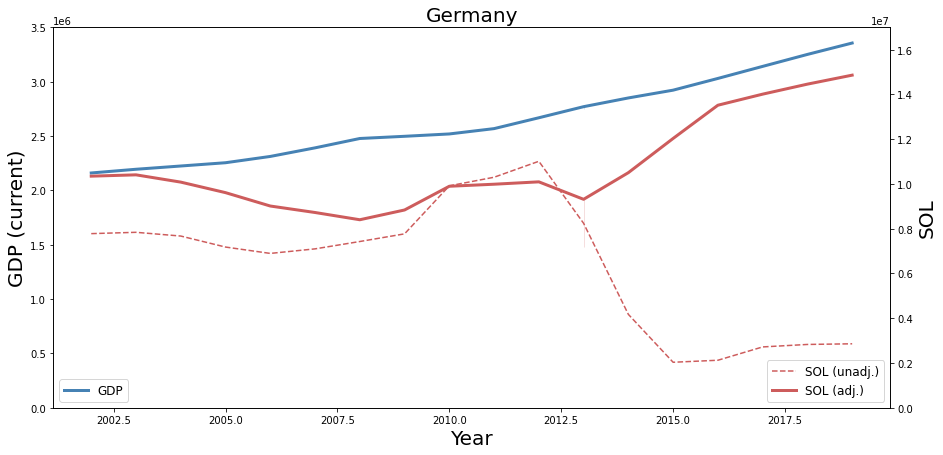

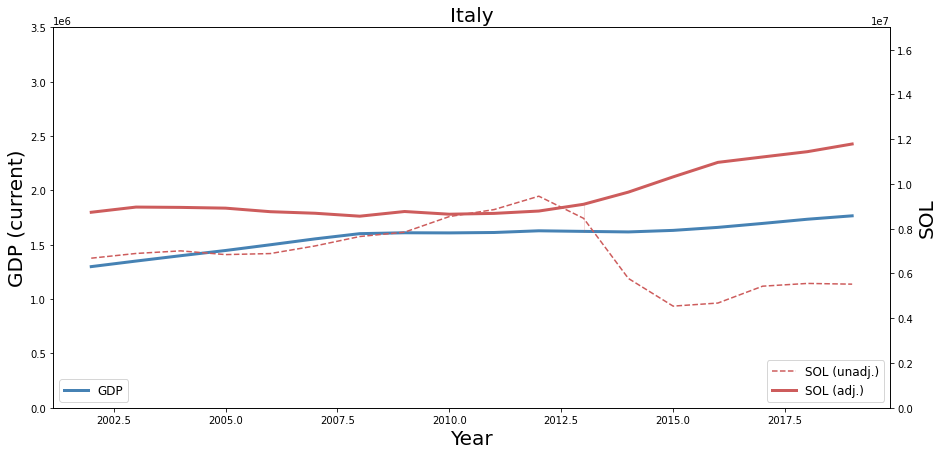

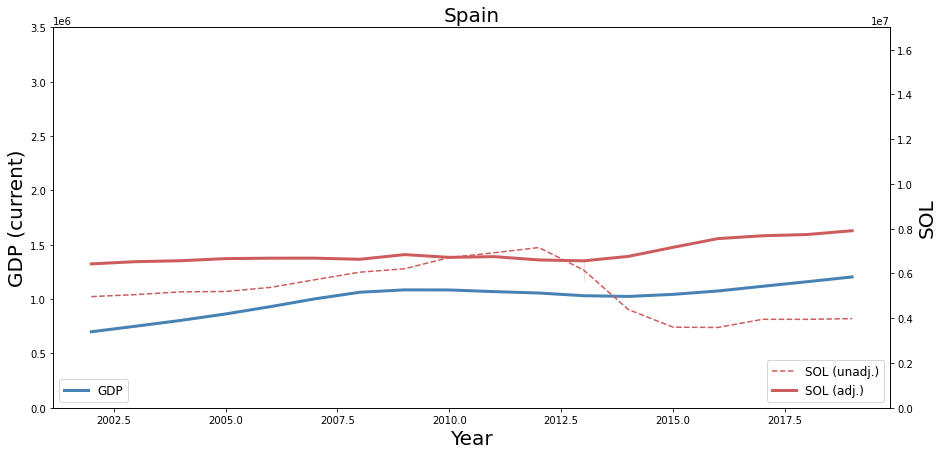

In [7]:
all_ts([de_gdp, it_gdp, es_gdp], "unadj_sol", "adj_sol", "SOL (unadj.)", "SOL (adj.)",
           "SOL", ["Germany","Italy","Spain"])

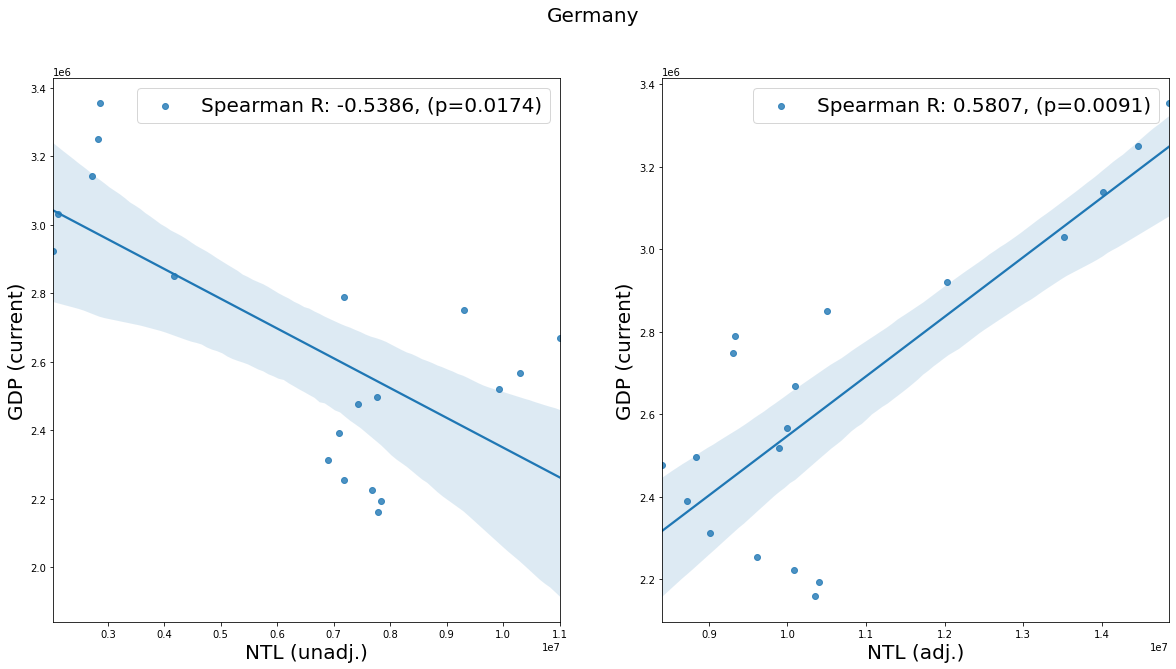

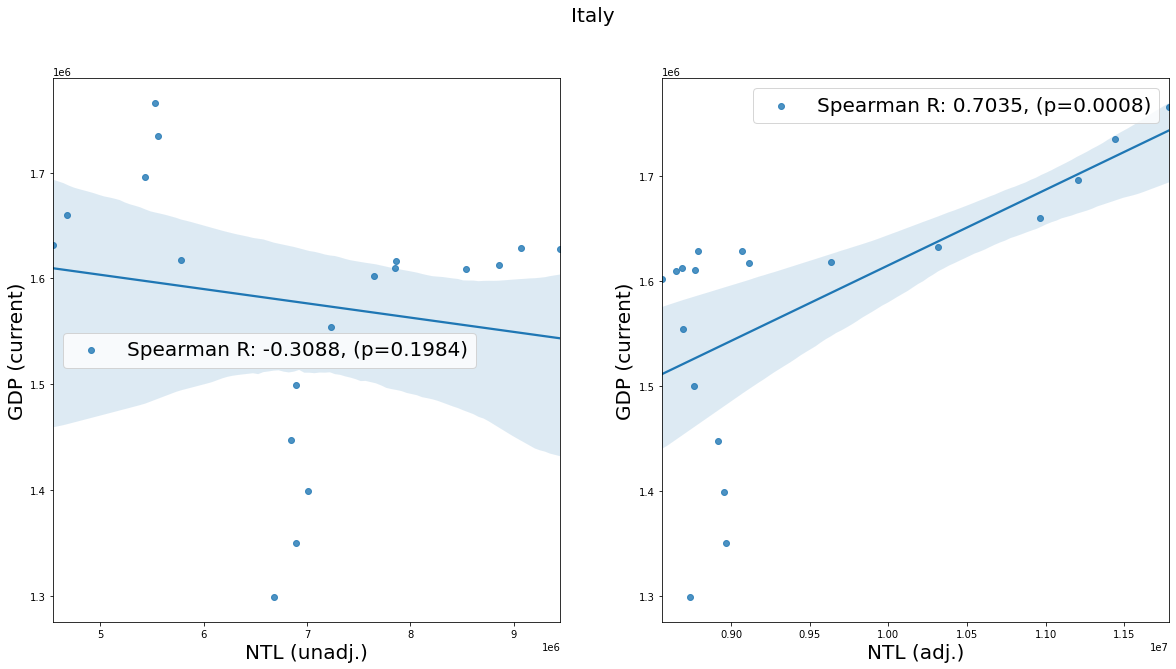

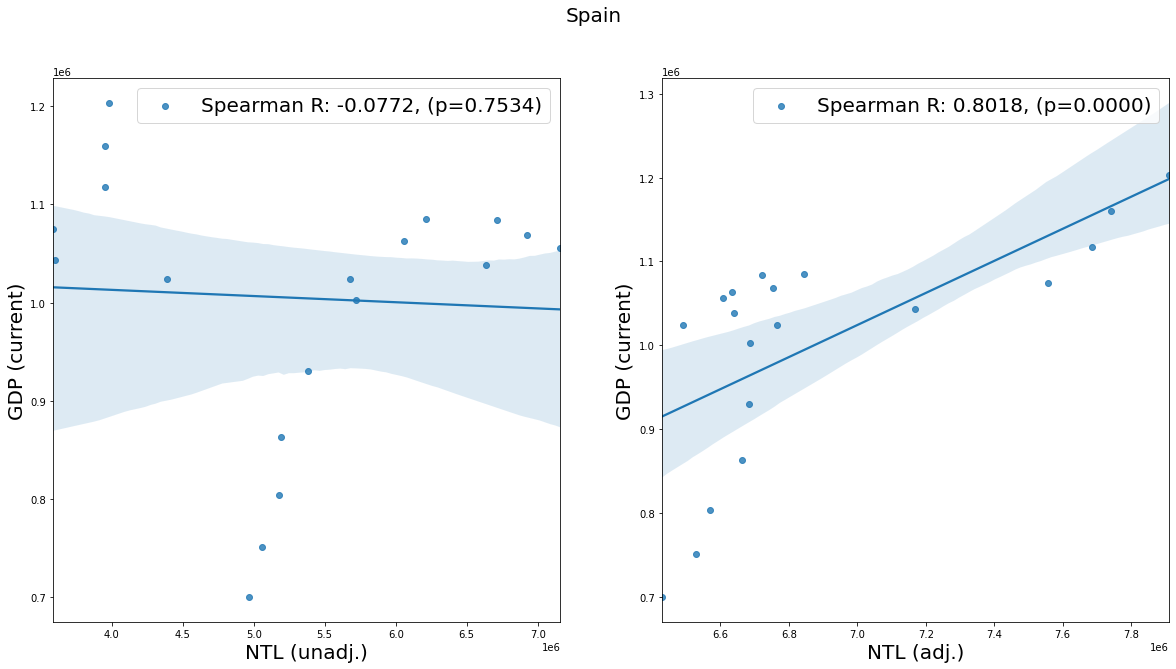

In [8]:
all_scatter([de_gdp, it_gdp, es_gdp], "unadj_sol", "adj_sol", ["Germany", "Italy", "Spain"], gdpcol="GDP")

In [9]:
de1_ntl = admin_extract_ts(country="DE", 
                       level=1, 
                       dmspindir=Path(DATA, "germany_admin1_rawDMSP"),
                       viirsindir=Path(DATA,"germany_admin1_rawVIIRS"),
                       outputdir=Path(OUTPUT, "GermanyAdmin1"),
                       thresh=1,
                       n_jobs=1)

es1_ntl = admin_extract_ts(country="ES", 
                       level=1, 
                       dmspindir=Path(DATA, "spain_admin1_rawDMSP"),
                       viirsindir=Path(DATA,"spain_admin1_rawVIIRS"),
                       outputdir=Path(OUTPUT, "SpainAdmin1"),
                       thresh=1,
                       n_jobs=1)

it1_ntl = admin_extract_ts(country="IT", 
                       level=1, 
                       dmspindir=Path(DATA, "italy_admin1_rawDMSP"),
                       viirsindir=Path(DATA,"italy_admin1_rawVIIRS"),
                       outputdir=Path(OUTPUT, "ItalyAdmin1"),
                       thresh=1,
                       n_jobs=1)

100%|██████████| 22/22 [00:00<00:00, 422.31it/s]

100%|██████████| 8/8 [00:00<00:00, 203.37it/s]

100%|██████████| 22/22 [00:00<00:00, 435.18it/s]

100%|██████████| 8/8 [00:00<00:00, 375.80it/s]

100%|██████████| 22/22 [00:00<00:00, 356.48it/s]

100%|██████████| 8/8 [00:00<00:00, 164.95it/s]

100%|██████████| 22/22 [00:00<00:00, 445.58it/s]

100%|██████████| 8/8 [00:00<00:00, 420.73it/s]

100%|██████████| 22/22 [00:00<00:00, 528.39it/s]

100%|██████████| 8/8 [00:00<00:00, 203.12it/s]

100%|██████████| 22/22 [00:00<00:00, 507.09it/s]

100%|██████████| 22/22 [00:00<00:00, 527.56it/s]

100%|██████████| 8/8 [00:00<00:00, 216.55it/s]

100%|██████████| 22/22 [00:00<00:00, 543.53it/s]

100%|██████████| 8/8 [00:00<00:00, 464.78it/s]

100%|██████████| 22/22 [00:00<00:00, 447.67it/s]

100%|██████████| 8/8 [00:00<00:00, 188.64it/s]

100%|██████████| 22/22 [00:00<00:00, 444.17it/s]

100%|██████████| 8/8 [00:00<00:00, 361.07it/s]

100%|██████████| 22/22 [00:00<00:00, 601.73it/s]

100%|██████████| 8

100%|██████████| 22/22 [00:00<00:00, 643.62it/s]

100%|██████████| 8/8 [00:00<00:00, 517.34it/s]

100%|██████████| 22/22 [00:00<00:00, 704.21it/s]

100%|██████████| 8/8 [00:00<00:00, 652.01it/s]

100%|██████████| 22/22 [00:00<00:00, 690.73it/s]

100%|██████████| 8/8 [00:00<00:00, 522.12it/s]

100%|██████████| 22/22 [00:00<00:00, 583.56it/s]

100%|██████████| 8/8 [00:00<00:00, 404.40it/s]

100%|██████████| 22/22 [00:00<00:00, 666.50it/s]

100%|██████████| 8/8 [00:00<00:00, 546.00it/s]

100%|██████████| 22/22 [00:00<00:00, 663.86it/s]

100%|██████████| 22/22 [00:00<00:00, 663.69it/s]

100%|██████████| 8/8 [00:00<00:00, 503.76it/s]

100%|██████████| 22/22 [00:00<00:00, 638.57it/s]

100%|██████████| 8/8 [00:00<00:00, 542.21it/s]

100%|██████████| 22/22 [00:00<00:00, 650.50it/s]

100%|██████████| 8/8 [00:00<00:00, 552.42it/s]

100%|██████████| 22/22 [00:00<00:00, 628.97it/s]

100%|██████████| 8/8 [00:00<00:00, 509.45it/s]

100%|██████████| 22/22 [00:00<00:00, 687.44it/s]

100%|██████████| 8

100%|██████████| 22/22 [00:00<00:00, 479.11it/s]

100%|██████████| 8/8 [00:00<00:00, 154.88it/s]

100%|██████████| 22/22 [00:00<00:00, 522.26it/s]

100%|██████████| 8/8 [00:00<00:00, 298.90it/s]

100%|██████████| 22/22 [00:00<00:00, 478.22it/s]

100%|██████████| 8/8 [00:00<00:00, 150.55it/s]

100%|██████████| 22/22 [00:00<00:00, 516.58it/s]

100%|██████████| 22/22 [00:00<00:00, 473.50it/s]

100%|██████████| 8/8 [00:00<00:00, 154.98it/s]

100%|██████████| 22/22 [00:00<00:00, 478.35it/s]

100%|██████████| 8/8 [00:00<00:00, 377.75it/s]

100%|██████████| 22/22 [00:00<00:00, 513.77it/s]

100%|██████████| 8/8 [00:00<00:00, 174.89it/s]

100%|██████████| 22/22 [00:00<00:00, 497.24it/s]

100%|██████████| 8/8 [00:00<00:00, 314.30it/s]

100%|██████████| 22/22 [00:00<00:00, 494.23it/s]

100%|██████████| 8/8 [00:00<00:00, 151.85it/s]

100%|██████████| 22/22 [00:00<00:00, 489.37it/s]

100%|██████████| 22/22 [00:00<00:00, 424.00it/s]

100%|██████████| 8/8 [00:00<00:00, 131.91it/s]

100%|██████████| 2

In [10]:
de1_gdp = get_country_data("DE",gdp, de1_ntl, level=1)
es1_gdp = get_country_data("ES",gdp, es1_ntl, level=1)
it1_gdp = get_country_data("IT",gdp, it1_ntl, level=1)

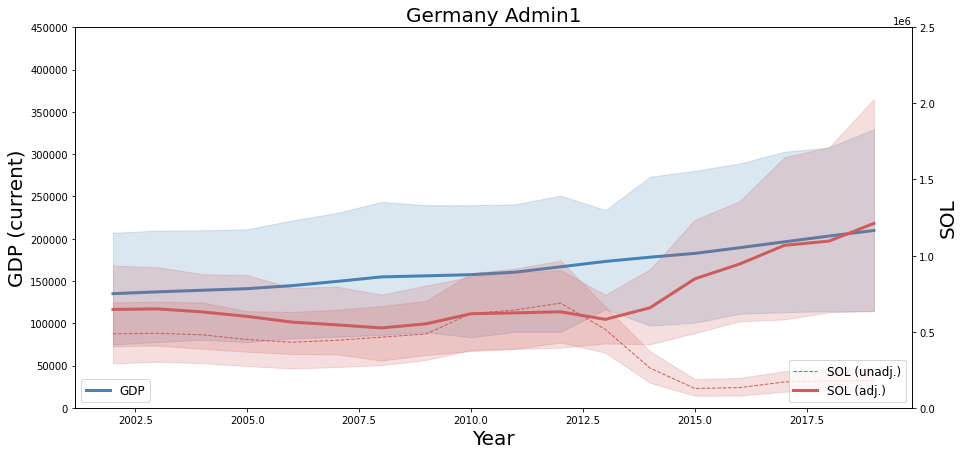

In [22]:
all_ts_admin([de1_gdp], "unadj_sol", "adj_sol", 
             "SOL (unadj.)", "SOL (adj.)","SOL", ["Germany Admin1"], gdpcol="GDP")

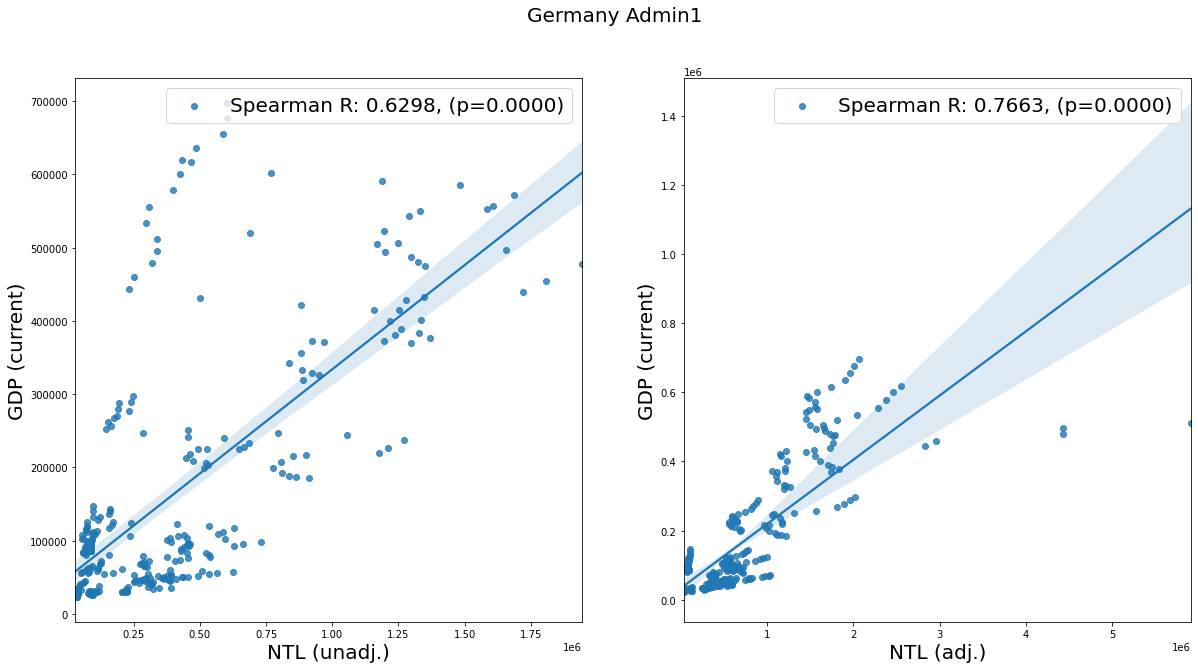

In [20]:
all_scatter_admin([de1_gdp], "unadj_sol", "adj_sol", ["Germany Admin1", ], gdpcol="GDP")